In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

https://www.kaggle.com/discussions/general/74235
follow instructions

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
#kaggle datasets download -d tusharpadhy/deepfake-dataset

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cecilia0999","key":"cc1406dbb42304ade9f37c8885076ba5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d tusharpadhy/deepfake-dataset


ref                                                     title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
syedanwarafridi/vehicle-sales-data                      Vehicle Sales Data                             19MB  2024-02-21 20:16:17           7973        140  1.0              
mahad049/job-placement-dataset                          Job placement dataset                           6KB  2024-03-03 08:18:12           1015         25  0.9411765        
yaminh/smartphone-sale-dataset                          Smartphones Sales Dataset                      65KB  2024-03-03 16:48:27           1094         22  0.88235295       
zain280/car-dataset                                     Car Dataset                                     1MB  2024-03-02 15:14:49  

In [ ]:
! mkdir dataset
! unzip deepfake-dataset.zip -d dataset

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import PIL
import urllib
import os
import torchvision
from torchvision import datasets, models, transforms


# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is enabled")
else:
    print("GPU is not enabled")

!nvidia-smi

In [ ]:
# Directories for your datasets
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
val_dir = '/content/dataset/valid'

# Transformation for resizing and converting images to Tensor
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])
batch_size = 32
num_workers = 0
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

# Mapping from index to class
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

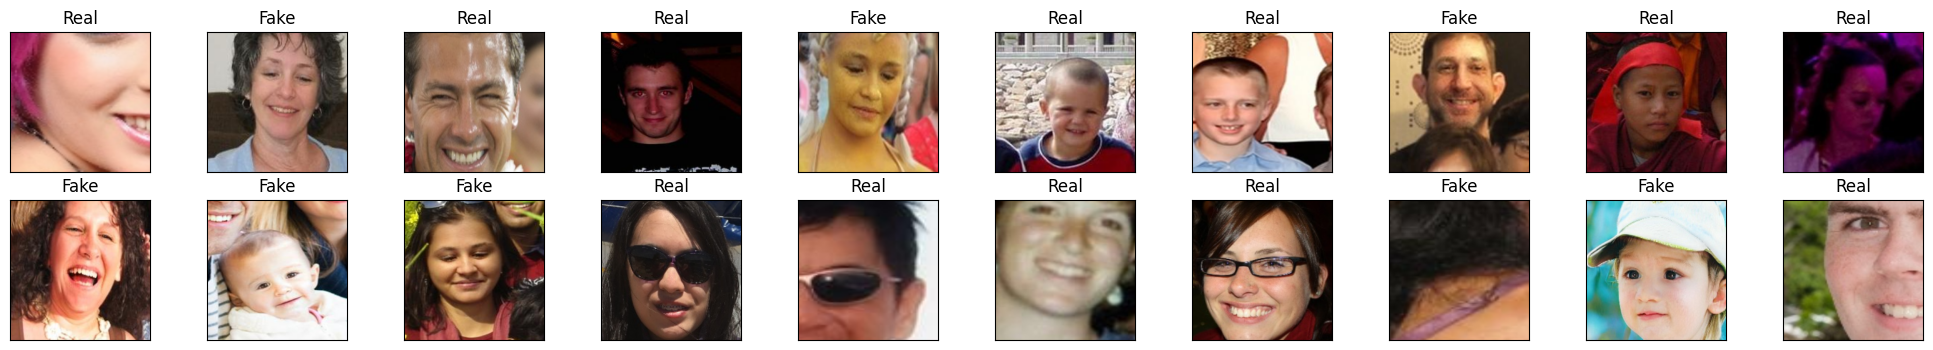

In [ ]:
# Visualize some sample data
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()  # Convert images to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    # Use the mapping to display the correct class name
    label = idx_to_class[labels[idx].item()]
    ax.set_title(label)

plt.show()

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

7501
1858
966


In [ ]:
torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

torch.Size([32, 256, 6, 6])

In [ ]:
use_cuda = True


ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

In [ ]:
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 128)  # Accepts flattened 256*6*6 features
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)  # Outputs a single value for binary classification

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # Raw score for binary classification, use BCEWithLogitsLoss
        return x

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:

        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(ALNC(imgs))

        # Apply threshold to convert probabilities to binary predictions
        pred = (output > 0.5).float()  # Assuming threshold of 0.5
        correct += (pred == labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:

def train(model, data, num_epochs=1,batch = 32):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch)
    criterion = nn.BCEWithLogitsLoss()  # Appropriate for binary classification
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

   # device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
   # model.to(device)

    # training
    n = 0  # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
       # Forward pass and compute the loss
            outputs = model(ALNC(imgs))
            labels = labels.view(-1, 1).float()
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Compute mini-batch accuracy
            predicted = torch.sigmoid(outputs) >= 0.5
            mini_batch_correct += predicted.eq(labels.byte()).sum().item()
            mini_batch_total += labels.size(0)
            train_acc.append((mini_batch_correct / mini_batch_total))

            # Save the current training information

            iters.append(n)
            losses.append(float(loss)/batch)
            val_acc.append(get_accuracy(model, train=False))
           # losses.append(loss.item())  # Average loss for this mini-batch
            n += 1
            mini_b += 1

        # Calculate and store accuracy for each epoch instead of each mini-batch

     #   val_acc.append(get_accuracy(model, val_loader))

        print(f"Epoch {epoch} Finished. Progress: {(epoch + 1) / num_epochs * 100:.2f}%, Time Elapsed: {time.time() - start_time:.2f} s")

    # plotting
    end_time= time.time()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Training Curve (Loss)")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.title("Accuracy Curve")
    plt.plot(range(num_epochs), train_acc, label="Training")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print(f"Final Training Accuracy: {train_acc[-1]*100:.2f}%")
    print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")
    print(f"Total time: {time.time() - start_time:.2f} s, Time per Epoch: {(end_time() - start_time) / num_epochs:.2f} s")


In [ ]:
model = ANNClassifier()
#proper model
train(model,[], batch=256, num_epochs=1)

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

In [ ]:
torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

In [ ]:
use_cuda = True
ALNC = alexNet.features
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 128)  # Accepts flattened 256*6*6 features
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 1)  # Outputs a single value for binary classification

    def forward(self, x):
        x = x.view(-1,256 * 6 * 6)  # Flatten the feature maps # error
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # Raw score for binary classification, use BCEWithLogitsLoss
        return x

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        outputs = model(ALNC(imgs))
        preds = outputs > 0.5  # Convert to 0/1 predictions based on threshold
        correct += (preds.view_as(labels) == labels).sum().item()
        total += imgs.shape[0]

    return correct / total

def train(model, data, batch_size=256, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            out = model(imgs) # assuming your model outputs raw scores
            loss = criterion(out.squeeze(), labels.float()) # adapt for binary class
            loss.backward() # backward pass (compute parameter updates)
            optimizer.step() # make the updates for each parameter
            optimizer.zero_grad() # a clean up step for PyTorch

            # Mini_batch Accuracy
            preds = out.squeeze().round() # Threshold predictions
            correct = preds.eq(labels).sum().item()
            total = imgs.size(0)
            train_acc.append(correct / total)

            # save the current training information
            iters.append(n)
            losses.append(float(loss) / batch_size) # compute *average* loss
            val_acc.append(get_accuracy(model, train=False)) # compute validation accuracy
            n += 1
            print("Iteration: ", n, "Loss: ", float(loss) / batch_size)

        print ("Epoch %d Finished. " % epoch)

    end_time = time.time()

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time: % 6.2f s Time per Epoch: % 6.2f s " % ((end_time - start_time), ((end_time - start_time) / num_epochs)))

In [ ]:
#shape '[-1, 9216]' is invalid for input of size 38535168, inspect with batch size
model = ANNClassifier()
if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
#proper model
train(model,train_dataset, batch_size=256, num_epochs=1)
print(train_dataset[0][0].shape)

In [ ]:
# Directories for your datasets
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
val_dir = '/content/dataset/valid'

# Transformation for resizing and converting images to Tensor
data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor()])
batch_size = 256
num_workers = 0
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

# Mapping from index to class
#idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
#idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
#idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

classes = ['Real', 'Fake']

#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(ALNC(imgs))

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size=20, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
                                           #num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          out = model(ALNC(imgs))             # forward pass
          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch





           ##### Mini_batch Accuracy ##### We don't compute accuracy on the whole training set in every iteration!
          pred = out.max(1, keepdim=True)[1]
          mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
          Mini_batch_total = imgs.shape[0]
          train_acc.append((mini_batch_correct / Mini_batch_total))
           ###########################

          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)             # compute *average* loss
          val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
          n += 1
          mini_b += 1
          print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_accuracy(model, train=True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
use_cuda = True

model = ANNClassifier()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model,[], batch_size=32, num_epochs=1)